<a href="https://colab.research.google.com/github/trehansalil/Py_Projects/blob/master/News_Summarization/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymongo[srv] transformers emoji rouge-score spacy seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 14.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4ccbfcc1fa9bfa39ba4f41054aa28b11ce99979bcc98cb171ec0987097ef5952
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
!kaggle datasets download -d shashichander009/inshorts-news-data

Dataset URL: https://www.kaggle.com/datasets/shashichander009/inshorts-news-data
License(s): unknown
 80% 10.0M/12.6M [00:00<00:00, 17.6MB/s]
100% 12.6M/12.6M [00:00<00:00, 14.6MB/s]


In [3]:
!unzip inshorts-news-data.zip

Archive:  inshorts-news-data.zip
  inflating: Inshorts Cleaned Data.xlsx  


In [5]:
from pymongo import MongoClient
import pandas as pd
from datetime import datetime, timezone
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW


# Requires the PyMongo package.
# https://api.mongodb.com/python/current

from google.colab import userdata
MONGO_DB_URI = userdata.get('MONGO_DB_URI')

client = MongoClient(MONGO_DB_URI)
filter={
    'updated_at': {
        '$gte': datetime(2023, 10, 1, 0, 0, 0, tzinfo=timezone.utc),
        '$lt': datetime(2025, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
    },
    'category': {
        '$ne': []
    }
}
sort=list({
    'updated_at': -1
}.items())

result = client['inshorts_db']['news_data'].find(
  filter=filter,
  sort=sort
)

df = pd.DataFrame.from_dict(result)

irrelevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()<1000].index]
relevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()>=1000].index]

print(irrelevant_categories)

df['category'] = df['category'].apply(lambda x: [i for i in x if i not in irrelevant_categories])

df.drop(index=df.loc[df['category'].apply(lambda x: x==[])].index, inplace=True)

df = df.reset_index(drop=True)

df.head()

['IPL', 'Lifestyle', 'EXPLAINERS', 'Feel_Good_Stories', 'experiment', 'Israel-Hamas_War', 'cricket', 'city', 'Russia-Ukraine_Conflict', 'crime', 'bollywood', 'Coronavirus', 'football', 'cryptocurrency', 'arts_and_entertainment', 'facts', 'Union_Budget_2023-24', 'Union_Budget_2024', 'environment', 'ODI_World_Cup_2023']


,_id,inshorts_url,author,category,created_at,date,datetime,day,headlines,image_url,original_source,read_more,relevancy_tags,text,updated_at
0,664c0b857fcaca29f8e557f4,https://inshorts.com/en/news/raisis-death-brin...,System User,"[miscellaneous, world]",2024-05-25 13:42:44.080,2024-05-20,2024-05-20 19:42:18,Monday,Raisi's death brings back memories of YSR copt...,https://nis-gs.pix.in/inshorts/images/v1/varia...,Deccanchronicle,https://www.deccanchronicle.com/nation/raisis-...,[],The reports on May 19 of the copter carrying I...,2024-05-25 13:42:44.080
1,6638a546e26671fb5398d828,https://inshorts.com/en/news/dhoni-jadeja-send...,FPJ Online Edit,"[hatke, sports]",2024-05-25 13:42:44.037,2024-05-05,2024-05-05 08:25:42,Sunday,"Dhoni, Jadeja send balls 'into the Himalayas' ...",https://nis-gs.pix.in/public/images/v1/variant...,Free Press Journal,https://www.freepressjournal.in/amp/sports/vid...,"[hatke, sports]",Former CSK captains MS Dhoni and Ravindra Jade...,2024-05-25 13:42:44.037
2,6640b721cb5e43d7e849db34,https://inshorts.com/en/news/maldives-replaces...,System User,"[world, national]",2024-05-25 13:42:43.926,2024-05-11,2024-05-11 14:34:01,Saturday,Maldives replaces 76 Indian military personnel...,https://nis-gs.pix.in/inshorts/images/v1/varia...,Thehawk,https://www.thehawk.in/posts/maldives-minister...,[],Maldivian Foreign Minister Moosa Zameer announ...,2024-05-25 13:42:43.926
3,6648f6384af552158744a685,https://inshorts.com/en/news/travis-head-discu...,System User,[sports],2024-05-25 13:42:43.867,2024-05-17,2024-05-17 17:47:32,Friday,"Travis Head discusses playing with Kohli, Gayl...",https://nis-gs.pix.in/inshorts/images/v1/varia...,Cricfit,https://cricfit.com/walking-into-that-dressing...,[],SRH's Travis Head recently reminisced about hi...,2024-05-25 13:42:43.867
4,663575f7e26671fb533c7053,https://inshorts.com/en/news/a-guide-to-what-a...,Mallika Bhagat,[travel],2024-05-25 13:42:43.803,2024-04-11,2024-04-11 10:35:38,Thursday,A guide to what awaits devotees at the 2024 Ch...,https://nis-gs.pix.in/inshorts/images/v1/varia...,Times Now,https://www.timesnownews.com/travel/destinatio...,[travel],Located in the Garhwal Himalayas and comprisin...,2024-05-25 13:42:43.803


In [6]:

kf = pd.read_excel('/content/Inshorts Cleaned Data.xlsx')[['Headline', 'Short']].rename(columns={'Headline': 'summary', 'Short': 'text'})

kf.head()

,summary,text
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [7]:
kf['text'][0], kf['summary'][0]

('The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.',
 '4 ex-bank officials booked for cheating bank of ₹209 crore')

In [8]:
df['category'].explode().value_counts()

category
national               5982
business               3918
sports                 3577
entertainment          2886
world                  2829
politics               2619
technology             1757
miscellaneous          1742
hatke                  1590
startup                1449
LOK_SABHA_ELECTIONS    1267
Health___Fitness       1180
science                1145
travel                 1143
fashion                1142
education              1057
automobile             1051
Name: count, dtype: int64

In [9]:
df['original_source'].value_counts()

original_source
Free Press Journal      1642
Hindustan Times         1264
Times Now               1249
The Indian Express       732
News18                   688
                        ... 
WTA                        1
ECB                        1
World Economic Forum       1
Independent                1
Manchester United          1
Name: count, Length: 605, dtype: int64

In [10]:
df.drop(columns=['inshorts_url', 'author', 'created_at', 'updated_at',
                 'datetime', 'date', 'day', 'original_source',
                 'read_more', 'relevancy_tags'],inplace=True)

### News Summarization

In [11]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim':300,
          'embedding_dim':200}

In [13]:
raw = df[['text', 'headlines']].rename(columns={'headlines': 'summary'})

raw = pd.concat([raw, kf], axis=0).reset_index(drop=True)

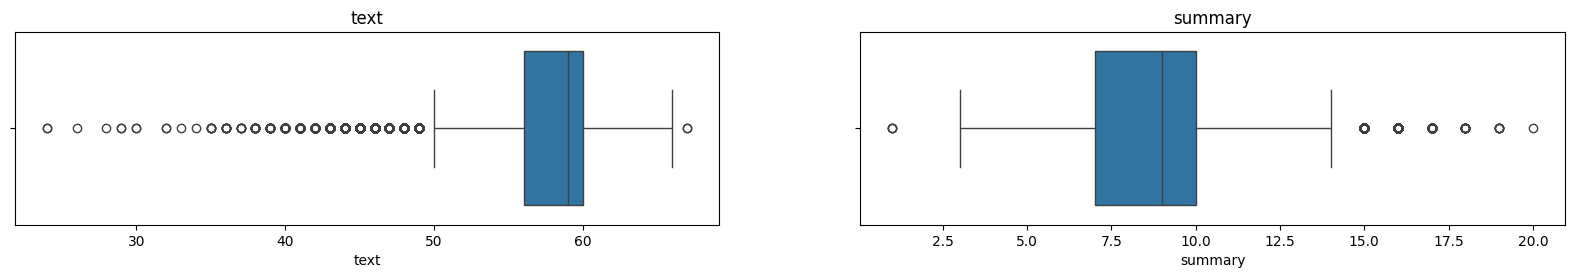

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(raw['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(raw['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [15]:
print(f'berore filtering: {raw.shape}')
pre = raw.loc[(raw['text'].str.split(" ").str.len()>config['min_text_len']) & (raw['text'].str.split(" ").str.len()<config['max_text_len'])].reset_index(drop=True)
print(f'after filtering: {pre.shape}')

berore filtering: (80200, 2)
after filtering: (48998, 2)


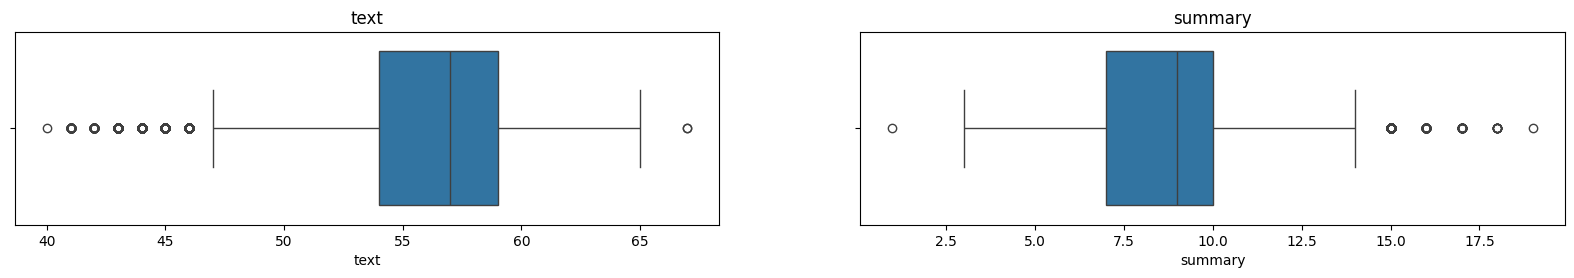

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(pre['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(pre['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [17]:
ind = 1
print(f'Text: {pre.text[ind]}')
print('')
print(f'Summary: {pre.summary[ind]}')
print('')
print(f'Text length: {len(pre.text[ind].split())}')
print(f'Summary length: {len(pre.summary[ind].split())}')

Text: Maldivian Foreign Minister Moosa Zameer announced the replacement of 76 Indian military personnel with civilians from Hindustan Aeronautics Limited. The move, part of a broader defense collaboration with India, aims to maintain peace in the Indian Ocean. The personnel transition occurred in phases across multiple locations, with all military roles now civilian-operated.

Summary: Maldives replaces 76 Indian military personnel with civilians

Text length: 52
Summary length: 8


In [18]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import re

# remove non-alphabetic character
def text_strip(sentence):

    sentence = re.sub("(\\t)"," ",str(sentence)).lower()
    sentence = re.sub("(\\r)"," ",str(sentence)).lower()
    sentence = re.sub("(\\n)"," ",str(sentence)).lower()

    # remove - if it occours more than one time
    sentence = re.sub("(--+)"," ",str(sentence)).lower()

    # remove . if it occours more than one time
    sentence = re.sub("(\.\.+)"," ",str(sentence)).lower()

    # remove special characters
    sentence = re.sub(r"[-<>()|&©⌀\[\]\'\",;?*!]"," ",str(sentence)).lower()

    # remove \x9* in text
    sentence = re.sub(r"(\\x9\d)"," ",str(sentence)).lower()

    # replace CH# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)","CM_NUM",str(sentence)).lower()

    # remove punctuations at the end of the word
    sentence = re.sub("(\.\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\-\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\:\s+)"," ",str(sentence)).lower()

    # remove multiple spaces
    sentence = re.sub("(\s+)"," ",str(sentence)).lower()

    return sentence

In [21]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '__START__' + text_strip(x) + '__END__')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre

,text,summary,cleaned_text,cleaned_summary
0,The reports on May 19 of the copter carrying I...,Raisi's death brings back memories of YSR copt...,the reports on may 19 of the copter carrying i...,sostok __START__raisi s death brings back memo...
1,Maldivian Foreign Minister Moosa Zameer announ...,Maldives replaces 76 Indian military personnel...,maldivian foreign minister moosa zameer announ...,sostok __START__maldives replaces 76 indian mi...
2,SRH's Travis Head recently reminisced about hi...,"Travis Head discusses playing with Kohli, Gayl...",srh s travis head recently reminisced about hi...,sostok __START__travis head discusses playing ...
3,Located in the Garhwal Himalayas and comprisin...,A guide to what awaits devotees at the 2024 Ch...,located in the garhwal himalayas and comprisin...,sostok __START__a guide to what awaits devotee...
4,Pune police have arrested the father of the 17...,Father of 17-year-old who killed 2 with speedi...,pune police have arrested the father of the 17...,sostok __START__father of 17 year old who kill...
...,...,...,...,...
48993,A beedi tycoon from Kerala&#39;s Thrissur dist...,Kerala tycoon guilty of guard&#39;s murder wit...,a beedi tycoon from kerala #39 s thrissur dist...,sostok __START__kerala tycoon guilty of guard ...
48994,Maharashtra’s state cultural department is org...,Maharashtra to host Raigad festival from Jan 21,maharashtra’s state cultural department is org...,sostok __START__maharashtra to host raigad fes...
48995,"Two militants, who were reportedly holed up in...",2 militants killed in encounter in J&amp;K&#39...,two militants who were reportedly holed up ins...,sostok __START__2 militants killed in encounte...
48996,Researchers from the Georgia Institute of Tech...,New lab for remote access to robots being built,researchers from the georgia institute of tech...,sostok __START__new lab for remote access to r...


In [22]:
print(pre.shape)
post_pre = pre[((pre['cleaned_text'].str.split().str.len()<=config['max_text_len']) & (pre['summary'].str.split().str.len()<=(config['max_summary_len']+4)))].copy()
post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)
post_pre = post_pre.drop(['text','summary'],axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre

(48998, 4)
(29889, 4)


,text,summary
0,the reports on may 19 of the copter carrying i...,sostok __START__raisi s death brings back memo...
1,maldivian foreign minister moosa zameer announ...,sostok __START__maldives replaces 76 indian mi...
2,srh s travis head recently reminisced about hi...,sostok __START__travis head discusses playing ...
3,located in the garhwal himalayas and comprisin...,sostok __START__a guide to what awaits devotee...
4,pune police have arrested the father of the 17...,sostok __START__father of 17 year old who kill...
...,...,...
29884,microsoft on tuesday announced the acquisition...,sostok __START__microsoft buys custom version ...
29885,a beedi tycoon from kerala #39 s thrissur dist...,sostok __START__kerala tycoon guilty of guard ...
29886,maharashtra’s state cultural department is org...,sostok __START__maharashtra to host raigad fes...
29887,two militants who were reportedly holed up ins...,sostok __START__2 militants killed in encounte...


In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre['text']),
                                                      np.array(post_pre['summary']),
                                                      test_size = 0.1,
                                                      shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((26900,), (2989,), (26900,), (2989,))

In [24]:

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(list(x_train))

In [25]:
def get_rare_words(text_col):

    # prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))

    thresh = 5
    cnt = 0
    total_count = 0

    for key, value in text_tokenizer.word_counts.items():
        total_count = total_count + 1
        if value < thresh:
            cnt = cnt + 1

    print('% of rare words in vocabulary:',(cnt/total_count)*100)

    return cnt, total_count


x_train_cnt, x_train_total_count = get_rare_words(x_train)

% of rare words in vocabulary: 68.2632419250136


In [26]:
x_tokenizer = Tokenizer(num_words = x_train_total_count-x_train_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequence to integer sequence
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen = config['max_text_len'],padding='post')
x_val = pad_sequences(x_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
x_voc = x_tokenizer.num_words +1

print('vocabulary size: ', x_voc)

vocabulary size:  18090


In [27]:

y_train_cnt, y_train_total_cnt = get_rare_words(y_train)

% of rare words in vocabulary: 73.46135867871611


In [28]:
y_tokenizer = Tokenizer(num_words = y_train_total_cnt-y_train_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequence to integer sequence
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

# pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = config['max_text_len'],padding='post')
y_val = pad_sequences(y_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
y_voc = y_tokenizer.num_words +1

print('vocabulary size: ',y_voc)

vocabulary size:  6814


In [33]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output1,state_h,state_c) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output2,state_h,state_c) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs,state_h,state_c) = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc,embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state)= decoder_lstm(dec_emb,initial_state=[state_h,state_c])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_inputs, decoder_inputs],decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 60, 200)              3618000   ['input_3[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 60, 300),            601200    ['embedding_2[0][0]']         
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                            

In [34]:
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = './model.h5'

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
# Eralystopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [35]:
history = model.fit(
    [x_tr,y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)[:, 1:],
    epochs =500,
    callbacks = [es, save_model],
    batch_size = 764,
    validation_data = ([x_val,y_val[:, :-1]],
                       y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:, 1:])
                    )

Epoch 1/500
36/36 [==============================] - ETA: 0s - loss: 3.4947 - accuracy: 0.7885
Epoch 1: val_loss improved from inf to 1.34265, saving model to ./model.h5
36/36 [==============================] - 88s 2s/step - loss: 3.4947 - accuracy: 0.7885 - val_loss: 1.3427 - val_accuracy: 0.8128
Epoch 2/500
36/36 [==============================] - ETA: 0s - loss: 1.3021 - accuracy: 0.8221
Epoch 2: val_loss improved from 1.34265 to 1.22993, saving model to ./model.h5
36/36 [==============================] - 62s 2s/step - loss: 1.3021 - accuracy: 0.8221 - val_loss: 1.2299 - val_accuracy: 0.8294
Epoch 3/500
36/36 [==============================] - ETA: 0s - loss: 1.2420 - accuracy: 0.8273
Epoch 3: val_loss improved from 1.22993 to 1.18026, saving model to ./model.h5
36/36 [==============================] - 63s 2s/step - loss: 1.2420 - accuracy: 0.8273 - val_loss: 1.1803 - val_accuracy: 0.8329
Epoch 4/500
36/36 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.8351


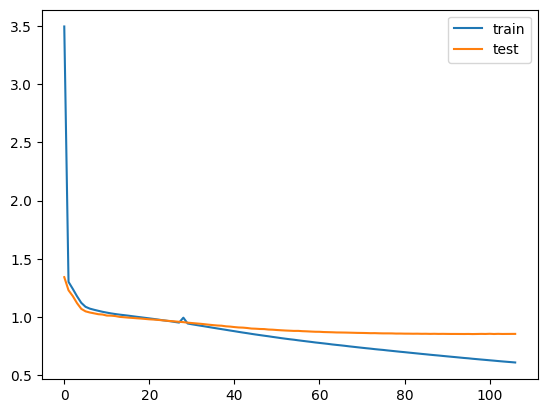

In [36]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

In [37]:
model.load_weights('./model.h5')

In [38]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [39]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [42]:
from tqdm import tqdm
actual = []
predicted = []
for i in tqdm(range(0,50)):
    print('Review:', seq2text(x_tr[i]))

    actual.append(seq2summary(y_tr[i]))
    print('Original Summary', actual[-1])

    predicted.append(decode_sequence(x_tr[i].reshape(1,config['max_text_len'])))
    print('Prdicted Summary', predicted[-1])
    print()

prediction_df = pd.DataFrame({'Actual':actual,'Predicted':predicted})
prediction_df.head(10)

  0%|          | 0/50 [00:00<?, ?it/s]

Review: the ministry of heavy industries has sanctioned ₹800 crore under fame india scheme phase ii to three psu oil marketing companies for setting up 7 public fast charging electric vehicle ev stations across the country the ministry has released crore or 70 of the total amount to three oil bharat petroleum and hindustan the first instalment 
Original Summary start cr for 7 fast charging ev stations end 
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 1/50 [00:02<01:39,  2.03s/it]

Prdicted Summary  start govt to launch its own for women 39 s next end

Review: nestled in the dehradun district mussoorie dubbed the queen of the hills invites travelers with its timeless charm whether you crave tranquility in nature s embrace or seek adventure mussoorie has it all explore the coolest activities in this picturesque destination and embark on a journey of discovery and delight tailored to every taste and season 
Original Summary start explore the of end 
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 2/50 [00:02<00:57,  1.21s/it]

Prdicted Summary  start video explains why end

Review: the national commission for protection of child rights has asked five states to collect samples of baby powder and manufactured by johnson amp johnson for laboratory testing notably this comes amid a number of us courts ruling against the firm over alleged lack of warning about health risks particularly the presence of carcinogenic substances of its based products 
Original Summary start child rights body orders testing of j amp j products end 
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 3/50 [00:03<00:54,  1.17s/it]

Prdicted Summary  start govt to give ₹1 cr to be withdrawn from end

Review: nidhi s secret a homemade hair oil business was built using nidhi dua s grandmother s traditional recipe along with her mother in law dua the software engineer has developed a thriving business out of an age old recipe while making them both financially independent 
Original Summary start woman mother in law launch hair oil biz earn rs 50 lakh month end 
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 4/50 [00:05<00:56,  1.23s/it]

Prdicted Summary  start video shows beauty of solar eclipse after being sold in the world end

Review: specialty coffee brand has raised 3 4 million in a series a funding round led by nexus venture partners venture partners an existing investor also participated the startup plans to use the raised capital to enhance its supply chain and technological advancements with the ultimate goal of delivering on demand coffee more efficiently and 
Original Summary start coffee brand raises 3 4 million in funding end 
1/1 [==============================] - 0s 38ms/step


 10%|█         | 5/50 [00:06<00:51,  1.15s/it]

Prdicted Summary  start raises 1 million from capital end

Review: iim bangalore 39 s entrepreneurship summit 39 2016 39 is set to begin from august 6 the two day summit would be a platform for entrepreneurs to showcase their ideas through events including to vcs workshops and panel discussions author and leadership consultant and actors kunal kapoor and piyush mishra will be attending the summit 
Original Summary start iim b summit to begin from aug 6 end 
1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 6/50 [00:08<01:03,  1.44s/it]

Prdicted Summary  start india s first timer s guide to the best of the world end

Review: amid the ongoing financial crisis edtech startup byju’s has reportedly given up all its office spaces in india except its headquarters in bengaluru to cut costs the decision to shut the offices in the country is a part of byju’s india ceo arjun restructuring plan 
Original Summary start byju s closes most offices adopts complete work from home end 
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 7/50 [00:09<00:59,  1.37s/it]

Prdicted Summary  start govt to launch new currency notes worth ₹2 crore end

Review: us probes if boeing 787 inspection records faa crucial inspections on after potential lapses surfaced boeing conducts re inspections and addresses systemic quality control issues concerns arise following an alaska airlines incident observers await boeing s leadership changes glass lewis advises against s re election due to safety culture concerns 
Original Summary start boeing probed in us over possible records on end 
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 8/50 [00:10<00:52,  1.25s/it]

Prdicted Summary  start air india express to be integrated into india s end

Review: russia has launched a global recruitment drive to from 21 countries including india serbia and cuba a report stated the report claimed that russia is deceiving foreign civilians into accepting combat roles by promising well paid non combat positions and is primarily targeting migrants and students at least two indians have passed away while serving in russian army 
Original Summary start russia hiring from 21 nations including india cuba report end 
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

Prdicted Summary  start india to get 1st time to be for india s first time in india end

Review: after the police killed eight simi members who had allegedly escaped from a high security jail in bhopal two videos have surfaced that have reportedly raised doubts over the authenticity of the encounter in one video a brand new knife is seen getting recovered from a body another video is as showing that they wanted to surrender reports stated 
Original Summary start videos raise over simi encounter reports end 
1/1 [==============================] - 0s 21ms/step


 20%|██        | 10/50 [00:13<00:51,  1.29s/it]

Prdicted Summary  start pak army seizes heroin worth cr in j amp k end

Review: amazon has promoted its india head amit agarwal to the post of senior vice president making him one of the few at amazon globally agarwal will however continue to head amazon india in april last year agarwal was inducted in the core team of amazon founder and ceo jeff bezos 
Original Summary start amazon 39 s india head amit agarwal as senior vp end 
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 11/50 [00:14<00:48,  1.25s/it]

Prdicted Summary  start india s 1st indian students get free number of india end

Review: elon musk s tesla is in talks with mukesh ambani s reliance industries ltd ril for a possible joint venture to build tesla s manufacturing facility in india hindu reported talks are at initial stages and have been ongoing for over a month the report added ril will only build capacities for electric vehicles in india the report added 
Original Summary start ambani s reliance musk s tesla in talks to make cars in india report end 
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 12/50 [00:15<00:45,  1.20s/it]

Prdicted Summary  start tesla s tesla layoffs in india s tesla report end

Review: a woman who filed a rape case against her partner told a navi mumbai court that her 6 year old son shot an intimate video of the couple the video was given in the court as evidence the court found the video was shot by a third person and the woman confirmed her son filmed it 
Original Summary start child shoots sex video couple booked end 
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 13/50 [00:16<00:45,  1.22s/it]

Prdicted Summary  start video shows man in bengaluru after being beaten up to death end

Review: a 25 year old software engineer identified as akmal lost his life after falling into an underground water built at his hostel in nagar on sunday as per reports the local police have taken action by registering a case against the hostel owner for negligence in maintaining safety measures specifically for leaving the open 
Original Summary start video techie dies after falling into water tank in hyderabad end 
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 14/50 [00:17<00:43,  1.21s/it]

Prdicted Summary  start man dies after falling off cliff after being hit in end

Review: a reduction in water reservoir levels due to heatwaves can impact access to water for agricultural activity experts said this can make vegetables and increase food inflation which may influence rbi s monetary policies they said heatwaves also reduce workforce s productivity impact construction activity increase pressure on power affect crop yields and reduce rural incomes 
Original Summary start how can impact indian economy end 
1/1 [==============================] - 0s 32ms/step


 30%|███       | 15/50 [00:18<00:38,  1.10s/it]

Prdicted Summary  start what is the symptoms of end

Review: current national ski champion arif khan has started a crowdfunding campaign to raise funds to participate in the upcoming asian winter games and the south korea winter olympics in 2018 arif who has received no financial assistance from the government has managed to raise over ₹2 lakh of the ₹10 lakh he needs to fund his training and equipment 
Original Summary start national champion seeks crowdfunding to go for olympics end 
1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 16/50 [00:20<00:41,  1.21s/it]

Prdicted Summary  start india 39 s first ever to be auctioned for end

Review: us police have arrested a man carrying a rifle after he entered a pizza restaurant to 34 self investigate 34 fake news reports that claimed it was operating a child abuse ring led by us presidential candidate hillary clinton the suspect reportedly pointed a gun at an employee who fled and notified the authorities no injuries have been reported 
Original Summary start by fake news attacks us restaurant end 
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 17/50 [00:21<00:42,  1.28s/it]

Prdicted Summary  start man dies after falling ill in delhi airport end

Review: gujarat titans star kane williamson was seen trying various traditional gujarat based as the franchise s official social media handles uploaded a clip of the same the right handed batter was seen trying dishes like and in what was described by the host as the gujarati taste challenge 
Original Summary start video kane williamson on gujarati food end 
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 18/50 [00:22<00:39,  1.25s/it]

Prdicted Summary  start video shows man s reaction after being shot dead in mumbai end

Review: mobile payment startup mobikwik on friday raised 40 million in funding from nasdaq listed transaction processing services provider the south african company will integrate its 39 virtual card 39 technology into mobikwik 39 s wallets founded in 2009 gurgaon based mobikwik claims to have 32 million mobile wallet users and one lakh retailers onboard 
Original Summary start mobikwik receives 40 million in funding end 
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 19/50 [00:23<00:35,  1.14s/it]

Prdicted Summary  start raises 1 million in series a funding end

Review: in meghalaya is known to be the place in the world based on the average annual rainfall it receives according to the guinness world records the place receives an annual average rainfall of 11 the second place is in meghalaya with an average annual rainfall of 11 
Original Summary start the place in the world is in meghalaya end 
1/1 [==============================] - 0s 19ms/step


 40%|████      | 20/50 [00:24<00:32,  1.09s/it]

Prdicted Summary  start how to do do you know about the world end

Review: sachin tendulkar and coldplay 39 s lead vocalist chris martin visited a school in mumbai on friday ahead of the global citizen festival tendulkar and martin interacted with 120 school children and addressed issues like education gender equality and sanitation tendulkar later tweeted 34 had an amazing time with chris martin amp the kids coldplay 34 
Original Summary start tendulkar visits mumbai school with coldplay 39 s chris martin end 
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 21/50 [00:25<00:30,  1.05s/it]

Prdicted Summary  start deepika padukone attends t20 world cup 2024 squad end

Review: the national medical commission nmc on thursday said it has not sanctioned any new medical college or increase in the number of undergraduate or postgraduate seats in medical courses for 2024 25 so far rejecting reports suggesting otherwise as fake news the applications received for this academic year are still under process 
Original Summary start nmc claims if new medical colleges and seat increase end 
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 22/50 [00:26<00:28,  1.03s/it]

Prdicted Summary  start govt to give ₹1 cr to be withdrawn from end

Review: in jaisalmer there was no am no pm only opium as he takes us to what was once the room where guests would be at the ki this a series of five was commissioned in by singh for his five sons and is now a museum you can visit 
Original Summary start this in took 55 years to build end 
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 23/50 [00:27<00:29,  1.09s/it]

Prdicted Summary  start this is the of the of the of the of the morning end

Review: actor rishi kapoor while talking about his meeting with underworld don dawood ibrahim in 1988 said that he did not think there was anything wrong about it 34 by that time he had not gone against our country at least not done something as grave as he did later 34 added rishi referring to the 1993 mumbai blasts 
Original Summary start nothing wrong in meeting dawood ibrahim in rishi end 
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 24/50 [00:28<00:28,  1.11s/it]

Prdicted Summary  start video shows rahul gandhi as he is his own house in end

Review: in uttar pradesh 13 year old used an device to off monkeys threatening her and her infant sister at home she played a dog sound the monkeys away this quick thinking not only saved them but highlighted the innovative use of technology in emergencies 
Original Summary start up teen monkeys with s help end 
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 25/50 [00:29<00:26,  1.04s/it]

Prdicted Summary  start indian origin woman arrested for in delhi end

Review: a red alert has been sounded again in some districts of kerala following heavy rains over the past 24 hours the possibility of heavy rainfall has been predicted by the central meteorological department for ernakulam and thrissur districts palakkad wayanad kozhikode malappuram and pathanamthitta districts are put on orange alert 
Original Summary start heavy rains continue to kerala imd issues red alert end 
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 26/50 [00:30<00:23,  1.01it/s]

Prdicted Summary  start sensex nifty close to inr 25 cr end

Review: as many as 26 people were killed and 25 others were wounded when two suicide bombers attacked a wedding celebration in a village near the iraqi city of late on wednesday two more blasts had targetted security forces at the scene after the initial blasts according to reports however no group has claimed responsibility for the attack yet 
Original Summary start 26 killed at iraqi wedding celebrations in suicide attack end 
1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 27/50 [00:31<00:22,  1.01it/s]

Prdicted Summary  start man dies after eating in a day end

Review: an american brokerage firm predicts that ayodhya s ram mandir could attract over 5 crore tourists annually surpassing the of mecca and vatican city combined a 10 billion makeover new airport revamped railway station township improved road connectivity etc will likely drive a effect with new hotels and other economic activities the firm said in its report 
Original Summary start ayodhya set to eclipse vatican in spiritual tourism appeal end 
1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 28/50 [00:33<00:27,  1.26s/it]

Prdicted Summary  start india 39 s first ever to be auctioned for 1st time end

Review: ishowspeed got bitten by a dog in the streets of south korea speed encountered a woman in south korea who was carrying a dog and much like his nature he couldn t resist at the while the dog didn t do anything at first the small animal bit him when speed got too close to it 
Original Summary start ishowspeed at dog in south korea gets in return end 
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 29/50 [00:35<00:29,  1.42s/it]

Prdicted Summary  start man utd 39 s oldest player to be held in london end

Review: the election commission on tuesday directed the telangana government to payments under the rythu bharosa scheme until after the lok sabha elections are held in the state on may 13 eci directed that disbursement of balance instalment under the rythu bharosa scheme for season of 2023 will be only after completion of polls in the state 
Original Summary start rythu payments until after polls in telangana ec end 
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 30/50 [00:36<00:27,  1.38s/it]

Prdicted Summary  start pm modi extends warm wishes to campaign for lok sabha polls end

Review: japan is renowned for its breathtaking cherry blossoms or drawing visitors from around the world during the spring season the cherry blossom season varies across japan usually occurring in late march to early may here are some of the best places to witness the enchanting beauty of cherry blossoms in the country 
Original Summary start 10 best places to see in japan end 
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 31/50 [00:37<00:25,  1.34s/it]

Prdicted Summary  start world 39 s most expensive car in the world end

Review: india s nearly 77 lakh gig workers lack social security food delivery partners in delhi highlight their long working hours pressure to meet daily targets and the need to travel long distances for minimal pay amid severe heatwaves while political parties pledge reforms challenges persist stressing the necessity of solutions to address workers struggles 
Original Summary start india’s workers escape but face job end 
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 32/50 [00:38<00:22,  1.24s/it]

Prdicted Summary  start india s 1st indian students get bomb threat end

Review: following the terror attack in istanbul istanbul was a top global twitter trend on wednesday a user reacted to it by tweeting 34 i but today i do an extra prayer for all the victims of my hometown istanbul 34 34 still seeing humans but not humanity we 39 re all one istanbul 34 read another tweet 
Original Summary start istanbul trending on twitter today end 
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 33/50 [00:39<00:19,  1.12s/it]

Prdicted Summary  start 39 39 song from 39 39 released end

Review: denmark based electronics company has made a pair of noise cancelling earphones which have a lightning port at one of its ends the earphones claim to automatically adjust the noise cancellation level based on the user 39 s environment notably apple 39 s next iphone is rumoured to not have a headphone jack 
Original Summary start noise with lightning port made end 
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 34/50 [00:40<00:17,  1.07s/it]

Prdicted Summary  start how to see the world s best mothers end

Review: the syrian army has taken control of aleppo 39 s old city which had been held by rebels for the past four years uk based syrian observatory for human rights said on wednesday with this advance the syrian army backed by russia has now taken control of nearly 70 of the rebels 39 urban stronghold over the past two weeks 
Original Summary start syrian army seizes aleppo 39 s old city from rebels end 
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 35/50 [00:41<00:15,  1.06s/it]

Prdicted Summary  start trump 39 s 1st indian students in india end

Review: rohit sharma engaged in a hilarious banter with lsg spinner amit mishra in the video posted by the lsg on social media sharma could be heard asking mishra you are only three years older than me mishra revealed his age to which sharma replied in his trademark fashion we were in when you made your debut 
Original Summary start rohit sharma’s banter with amit mishra regarding age goes viral end 
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 36/50 [00:42<00:14,  1.06s/it]

Prdicted Summary  start video shows ipl 2024 playoff moment with ipl 2024 end

Review: nobel laureate dr paul on friday criticised the implementation of pm narendra modi 39 s demonetisation policy by calling it 34 unusual 34 while the motivation behind demonetisation is but the implementation of the policy is highly disruptive the american economist said further he also said that india must work on reducing poverty 
Original Summary start demonetisation policy is unusual nobel end 
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 37/50 [00:43<00:13,  1.02s/it]

Prdicted Summary  start govt to give money to be for end

Review: a new trailer of the sixth season of the fantasy drama television series 39 game of thrones 39 has been released the trailer features arya the white and it also shows glimpses of jon snow 39 s dead body the new season will premiere on hbo on april 24 
Original Summary start new trailer of game of thrones season 6 out end 
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 38/50 [00:44<00:11,  1.05it/s]

Prdicted Summary  start trailer of 39 39 released end

Review: shreyas talpade shared how shah rukh khan aimed for om shanti om to be the biggest blockbuster of 2007 as friends in the movie both khan and talpade spent a lot of time marketing plans even holding discussions while seated on a toilet pot in a london hotel room 
Original Summary start when srk om om strategy from toilet end 
1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 39/50 [00:45<00:11,  1.08s/it]

Prdicted Summary  start i am not to know about the of ipl 2024 end

Review: yogi adityanath condemns kejriwal s claims about pm modi s retirement as desperate opposition tactics ahead of the elections kejriwal suggested modi would make way for amit shah followed by adityanath s adityanath reaffirms modi s widespread support dismissing age based he underscores modi s commitment to national development and denies bjp succession speculations 
Original Summary start yogi adityanath slams modi retirement remarks end 
1/1 [==============================] - 0s 34ms/step


 80%|████████  | 40/50 [00:47<00:11,  1.17s/it]

Prdicted Summary  start pm modi extends birthday wishes to campaign end

Review: in an effort to boost the economy china’s central bank cut required reserve ratio by 0 5 banks will have to keep less of their money in cash and will be able to lend more to people and businesses thereby injecting money into the financial system the move could reportedly put further devaluation pressure on china’s currency the yuan 
Original Summary start china cuts banks 39 reserve ratio end 
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 41/50 [00:49<00:12,  1.40s/it]

Prdicted Summary  start india 39 s 39 39 s 39 39 39 39 39 39 released end

Review: cloud storage provider dropbox on thursday launched their windows 10 application for computers and tablets which will be available for download in the coming days the new application would allow the users to directly drag and drop their files from the windows file explorer it will also feature fingerprint face and iris scanner as authentication for the app 
Original Summary start launches win 10 app for and end 
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 42/50 [00:50<00:10,  1.29s/it]

Prdicted Summary  start new startup lets users to make its own end

Review: rohan murty grandson of infosys founder narayana murthy became a millionaire after his grandfather gifted him 15 lakh shares valued at around rs 240 crore a regulatory filing said the gift of 15 lakh shares to his grandson accounts for 0 04 percent of his equity holding making the youngest billionaire shareholder of infosys 
Original Summary start narayana murthy gifts shares worth cr to grandson end 
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 43/50 [00:51<00:08,  1.21s/it]

Prdicted Summary  start indian origin woman arrested for taking in mumbai end

Review: england have announced their odi and t20i squads for their white ball series against pakistan later this month with missing out on selection for both series also absent from england s t20i playing group from their previous series is she has however retained her place in the odi squad 
Original Summary start and miss out on england t20i squad vs pakistan end 
1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 44/50 [00:52<00:06,  1.15s/it]

Prdicted Summary  start man utd 39 s oldest player in london end

Review: south african model carla dennis who recently got married to indian singer arjun chose to wear designer anita dongre s creation for her function describing her pink outfit carla said i loved it the minute i saw it she said she felt like an absolute princess in the lehenga carla and arjun got married on august 10 
Original Summary start felt like a princess arjun s wife on outfit end 
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 45/50 [00:53<00:05,  1.17s/it]

Prdicted Summary  start watch why did the new captain for t20 wc 2024 end

Review: sensex on thursday gained 126 93 points to settle at 27 11 while the nse nifty breached the 8 550 mark for the first time in ten months to close at 8 00 gaining 45 50 points icici bank maruti suzuki and sbi were among the top gainers while ongc infosys and mahindra amp mahindra were among the major losers 
Original Summary start sensex gains 93 nifty up by 45 50 end 
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 46/50 [00:54<00:04,  1.10s/it]

Prdicted Summary  start sensex nifty close to inr 25 cr end

Review: according to the reserve bank of india governor urjit patel gets a little over ₹2 lakh in salary and has not been provided with any supporting staff at his residence two cars and two drivers have also been provided to patel his predecessor raghuram rajan last withdrew a salary of ₹2 09 lakh 
Original Summary start rbi governor patel gets ₹2 lakh in salary end 
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 47/50 [00:55<00:03,  1.08s/it]

Prdicted Summary  start rbi bars kotak mahindra bank for refusing to end

Review: former indian cricketer sunil gavaskar said that the indian team 39 s run of consecutive test wins under virat kohli is amazing and that the team is his unfulfilled dream speaking about his dreams gavaskar said that he always wanted to get west indies 39 batsmen rohan and garry out on back to back deliveries 
Original Summary start current indian team dreams i could not gavaskar end 
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 48/50 [00:56<00:02,  1.07s/it]

Prdicted Summary  start indian origin woman dies after falling ill in end

Review: former karnataka cm hd kumaraswamy said his nephew and former pm deve gowda s grandson prajwal revanna would be suspended following core committee meeting of jd s on tuesday this comes after the state government ordered probe into the videos allegedly showing him sexually abusing women prajwal has left the country amid the scandal 
Original Summary start ex pm gowda s grandson prajwal to be suspended from jd s amid sexual abuse scandal end 
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 49/50 [00:57<00:01,  1.04s/it]

Prdicted Summary  start bjp mla booked for murder in delhi end

Review: e commerce company amazon has been fined approximately ₹5 7 crore by canada 39 s competition bureau over misleading pricing practices amazon was advertising products on its platform as being cheaper than regular market prices the company was accused of giving users an inaccurate picture of how much they would be able to save by shopping on the website 
Original Summary start amazon fined ₹5 7 crore over misleading pricing in canada end 
1/1 [==============================] - 0s 26ms/step


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]

Prdicted Summary  start amazon india s first ever train fund end



,Actual,Predicted
0,start cr for 7 fast charging ev stations end,start govt to launch its own for women 39 s n...
1,start explore the of end,start video explains why end
2,start child rights body orders testing of j am...,start govt to give ₹1 cr to be withdrawn from...
3,start woman mother in law launch hair oil biz ...,start video shows beauty of solar eclipse aft...
4,start coffee brand raises 3 4 million in fundi...,start raises 1 million from capital end
5,start iim b summit to begin from aug 6 end,start india s first timer s guide to the best...
6,start byju s closes most offices adopts comple...,start govt to launch new currency notes worth...
7,start boeing probed in us over possible record...,start air india express to be integrated into...
8,start russia hiring from 21 nations including ...,start india to get 1st time to be for india s...
9,start videos raise over simi encounter reports...,start pak army seizes heroin worth cr in j am...


In [43]:
from rouge_score import rouge_scorer

r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rougeL','rougeL'],use_stemmer=True)

for index, data in prediction_df.iterrows():
    r_score = scorer.score(data.Actual, data.Predicted)
    pr = list(r_score['rougeL'])[0]
    rc = list(r_score['rougeL'])[1]
    f_meas = list(r_score['rougeL'])[2]

    rouge_pr.append(pr)
    rouge_rc.append(rc)
    rouge_f.append(f_meas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f
prediction_df.head(10)

,Actual,Predicted,rouge_pr,rouge_rc,rouge_f
0,start cr for 7 fast charging ev stations end,start govt to launch its own for women 39 s n...,0.250000,0.333333,0.285714
1,start explore the of end,start video explains why end,0.400000,0.400000,0.400000
2,start child rights body orders testing of j am...,start govt to give ₹1 cr to be withdrawn from...,0.181818,0.166667,0.173913
3,start woman mother in law launch hair oil biz ...,start video shows beauty of solar eclipse aft...,0.214286,0.200000,0.206897
4,start coffee brand raises 3 4 million in fundi...,start raises 1 million from capital end,0.571429,0.400000,0.470588
5,start iim b summit to begin from aug 6 end,start india s first timer s guide to the best...,0.214286,0.300000,0.250000
6,start byju s closes most offices adopts comple...,start govt to launch new currency notes worth...,0.181818,0.166667,0.173913
7,start boeing probed in us over possible record...,start air india express to be integrated into...,0.181818,0.200000,0.190476
8,start russia hiring from 21 nations including ...,start india to get 1st time to be for india s...,0.187500,0.272727,0.222222
9,start videos raise over simi encounter reports...,start pak army seizes heroin worth cr in j am...,0.166667,0.250000,0.200000


In [44]:
prediction_df[['rouge_pr', 'rouge_rc', 'rouge_f']].mean(axis=0)

rouge_pr    0.285709
rouge_rc    0.300066
rouge_f     0.287937
dtype: float64

### Category Prediction

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
from bs4 import BeautifulSoup
import re
import emoji
import string

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    # text = BeautifulSoup(text, 'lxml').get_text()
    # text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    # text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    # text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

df['text'] = df['text'].apply(text_preprocessing_pipeline)

df_labels = df['category'].apply(lambda x: ",".join(x)).str.get_dummies(sep=',')

df = df.join(df_labels)

In [ ]:
len(irrelevant_categories)

19

In [ ]:
len(relevant_categories)

17

In [ ]:
target_cols = [i for i in df_labels.columns]

In [ ]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.drop(columns=['_id', 'headlines', 'image_url']), test_size=0.2, random_state=42)


In [ ]:
len(df_train['category'].explode().value_counts().index)

17

In [ ]:
len(df_test['category'].explode().value_counts().index)

17

In [ ]:

train_loader = DataLoader(df_train, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(df_test, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 3786

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3761, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: 3786


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf

class HammingLoss(tf.keras.metrics.Metric):
    def __init__(self, name='hamming_loss', threshold=0.5, mode='multilabel', **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.mode = mode
        self.total_loss = self.add_weight(name='total_loss', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.mode == 'multilabel':
            y_pred = tf.cast(y_pred > self.threshold, tf.int32)
        elif self.mode == 'multiclassification':
            y_pred = tf.argmax(y_pred, axis=1)
            y_true = tf.argmax(y_true, axis=1)

        hamming_distance = tf.reduce_mean(tf.cast(y_true != y_pred, tf.float32))

        self.total_loss.assign_add(hamming_distance)
        self.count.assign_add(1)

    def result(self):
        return self.total_loss / self.count

    def reset_states(self):
        self.total_loss.assign(0)
        self.count.assign(0)



# Text Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
X_text = tokenizer.texts_to_sequences(df['text'])
X_text = pad_sequences(X_text, padding='post')

# Category Preprocessing
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['category'])

# Convert category labels to one-hot encoding
y = np.array(y)


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

metric = HammingLoss(mode='multilabel', threshold=0.8)

optimizer = tf.keras.optimizers.AdamW(
                learning_rate=0.001,
                weight_decay=0.004,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                loss_scale_factor=None,
                gradient_accumulation_steps=None,
                name='adamw',
            )

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', metric])

# Training the model
history = model.fit(X_text, y, epochs=10, batch_size=16, validation_split=0.2)


2024-05-19 18:25:17.806572: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.810026: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.842307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 18:25:20.242522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


TypeError: Input 'y' of 'NotEqual' Op has type int32 that does not match type int64 of argument 'x'.